

Install dependencies




In [1]:
# !pip install tensorflow-gpu==2.3 keras simpleitk matplotlib scikit-image pandas cupy

In [2]:
# pip uninstall tensorflow-gpu tensorflow keras

In [3]:
# pip install git+https://github.com/JihongJu/keras-resnet3d.git

Import Packages

In [4]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
# import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
# from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
# from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization as BN
# from keras.layers import GaussianNoise as GN
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, MaxPool3D, GlobalAveragePooling3D, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.utils import Sequence
# from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
# from skimage.util.montage import montage2d
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
# from sklearn import preprocessing
# import pandas as pd

from glob import glob

import SimpleITK as sitk
# import nibabel as nib

**Load and prepare data**

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# project_dir = "drive/MyDrive/Colab Notebooks/TFM/DATA/"

project_dir = "/home/pmeslaf/TFM/DATA/FIRST_VISIT_DATA_nougmented/"

In [6]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
# config = tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [7]:
batch_size = 2
epochs = 100
shape=128
classes = ["MCI", "AD", "CN"]
num_classes = len(classes) 
n_channels = 1
images_shape = (shape,shape,int(shape), n_channels)

Custom Image Generator

In [8]:
from data_generator import DataGenerator

**Prepare data**

In [9]:
training_generator = DataGenerator(data_path=project_dir + '/Train/',
                                   dim=images_shape[:-1],
                                   batch_size = batch_size,
                                   n_channels = n_channels,
                                   classes = classes,
                                #    flip=True,
                                #    zoom=1.5,
                                #    rotation=10,
                                   fourth_axis = False,
                                   shuffle=True)
valid_generator = DataGenerator(data_path=project_dir + '/Validation/',
                                   dim=images_shape[:-1],
                                   batch_size = batch_size,
                                   n_channels = n_channels,
                                   classes = classes,
                                   test=True,
                                   fourth_axis = False,
                                   shuffle=True)
test_generator = DataGenerator(data_path=project_dir + '/Test/',
                                   dim=images_shape[:-1],
                                   batch_size = batch_size,
                                   n_channels = n_channels,
                                   classes = classes,
                                   test=True,
                                   fourth_axis = False,
                                   shuffle=True)

3640 image(s) found in /home/pmeslaf/TFM/DATA/FIRST_VISIT_DATA_nougmented//Train/
58 image(s) found in /home/pmeslaf/TFM/DATA/FIRST_VISIT_DATA_nougmented//Validation/
126 image(s) found in /home/pmeslaf/TFM/DATA/FIRST_VISIT_DATA_nougmented//Test/


(128, 128, 128)


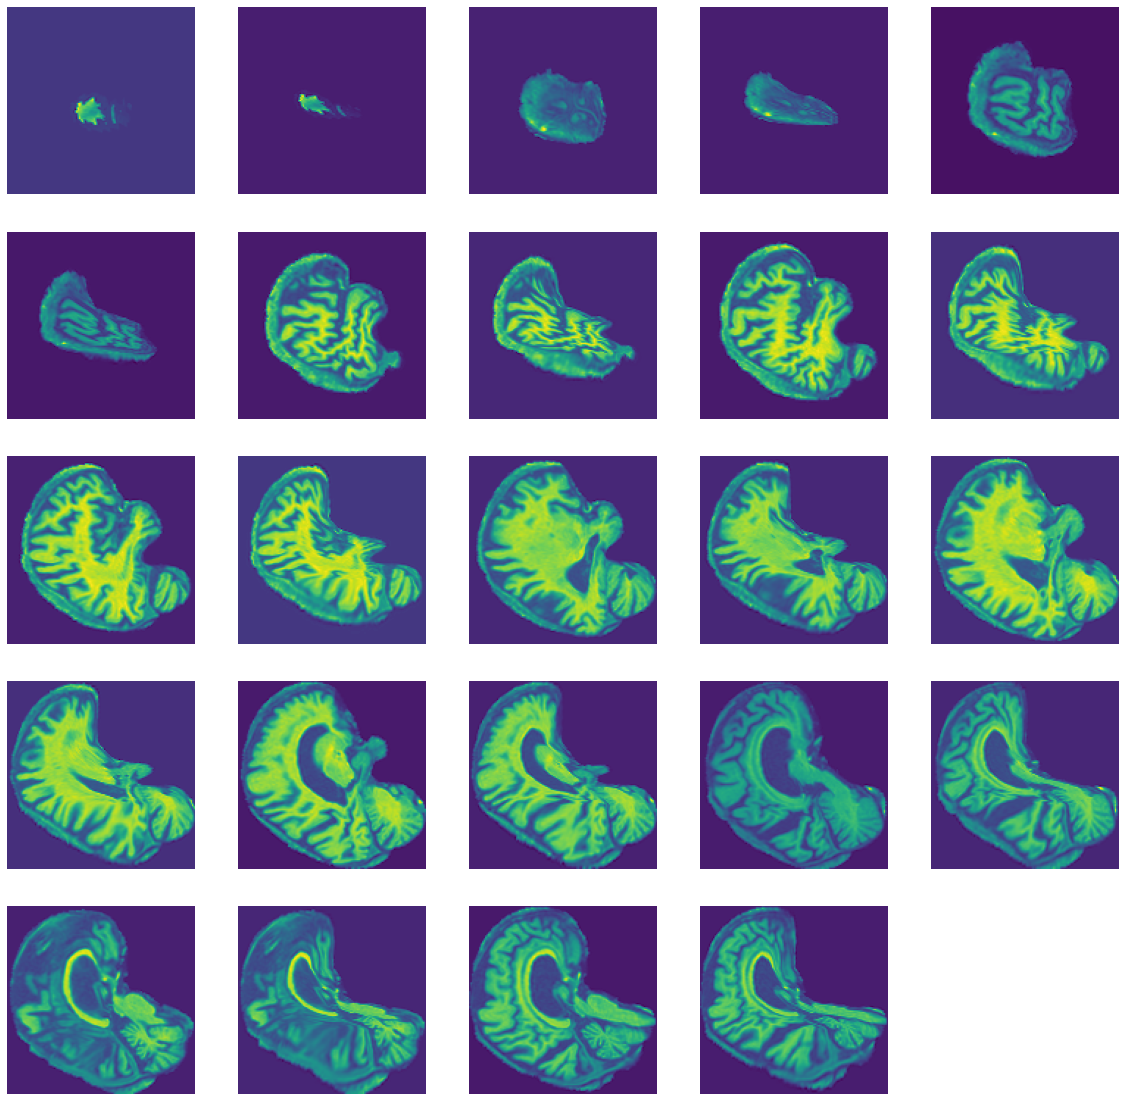

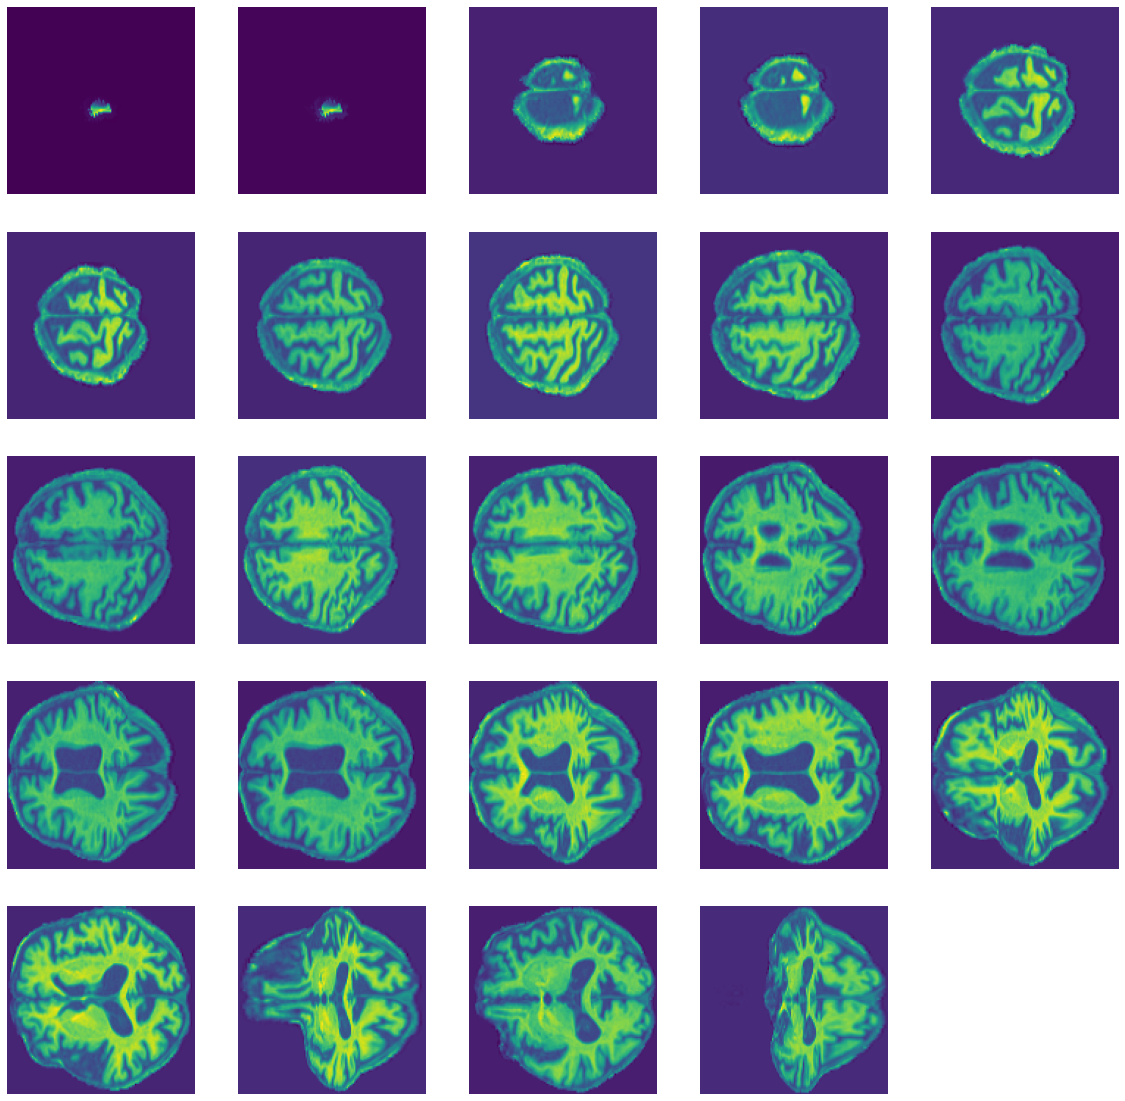

In [10]:
from Distort import Distort, GaussianDistortion

X, y = training_generator[0]
image = X[1]
print(image.shape)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image[i*10,:,:])
#   plt.axis("off")
# plt.show()

deformador = Distort(4, 4, 8)
deformador_gaussiano = GaussianDistortion(3, 3, 30, "bell", "in", 1.0, 1.0, 1.0, 1.0)
# augmented_img = deformador.perform_operation(image)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_img[i*10,:,:])
#   plt.axis("off")
# plt.show()

augmented_img = deformador_gaussiano.perform_operation(image)

plt.figure(figsize=(20, 20))
for i in range(0,24,2):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image[i*3,:,:])
  plt.axis("off")
  ax = plt.subplot(5, 5, i + 2)
  plt.imshow(augmented_img[i*3,:,:])
  plt.axis("off")
plt.show()

plt.figure(figsize=(20, 20))
for i in range(0,24,2):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image[:,:,i*3])
  plt.axis("off")
  ax = plt.subplot(5, 5, i + 2)
  plt.imshow(augmented_img[:,:,i*3])
  plt.axis("off")
plt.show()


In [11]:
# from vox_cnn_pseudo3D import voxCNN_pseudo3D
# from vox_cnn_p
# seudo3D_v2 import voxCNN_pseudo3D_V2
# from vox_cnn_pseudo3D_v3 import voxCNN_pseudo3D_V3

# model = voxCNN_pseudo3D(input_shape=images_shape[:-1], n_classes=num_classes) # batch=32

# # model.load_weights(project_dir + 'VoxCNN_pseudoRGB_E87_AD-CN_128_23-09-2021_01-19.0.8164.m5')

# pseudoRGB=model.get_layer('block0_pseudoRGB')

# X, y = training_generator[0]
# image = X[1]
# print(image.shape)

# # Add the image to a batch
# image = tf.expand_dims(image, 0)

# plt.figure(figsize=(20, 20))
# for i in range(9):
#   ax = plt.subplot(5, 5, i + 1)
#   augmented_image = pseudoRGB(image, training=True)
#   # print(augmented_image.shape)
#   plt.imshow(augmented_image[0])
#   plt.axis("off")

(128, 128, 128)


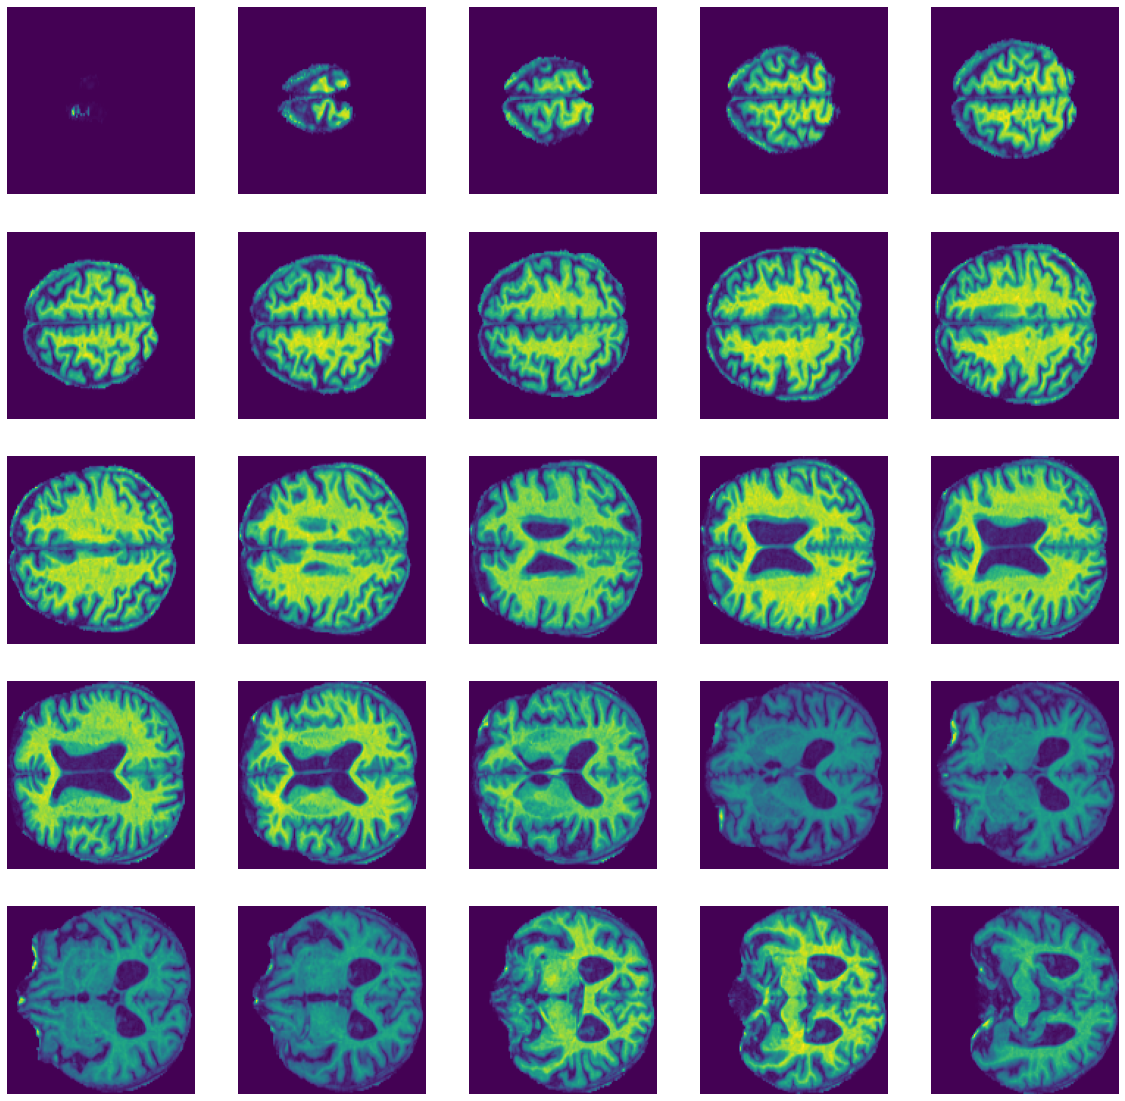

NotFoundError: No algorithm worked! [Op:Conv2D]

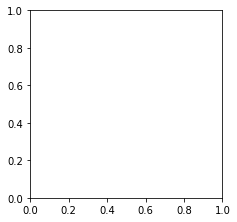

In [12]:

tf.keras.backend.set_floatx('float64')
data_augmentation = Sequential([
  # layers.experimental.preprocessing.RandomFlip("vertical"),
  layers.experimental.preprocessing.RandomContrast(0.9),
  # layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='nearest'), #nearest
  # layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='nearest'),
  # layers.experimental.preprocessing.RandomZoom(height_factor=0.3, fill_mode='nearest'),
  layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
  layers.Conv2D(33, (3, 3), activation='relu', padding='same'),
  layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
  layers.Conv2D(3, (3, 3), activation='relu', padding='same'),
])

X, y = test_generator[0]
image = X[1]
print(image.shape)
# plt.imshow(image[:,:,50], cmap ='gray')

plt.figure(figsize=(20, 20))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  # print(augmented_image.shape)
  plt.imshow(image[:,:,i*3])
  plt.axis("off")
plt.show()

# Add the image to a batch
image = tf.expand_dims(image, 0)

plt.figure(figsize=(20, 20))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  augmented_image = data_augmentation(image, training=True)
  # print(augmented_image.shape)
  plt.imshow(augmented_image[0,:,:,i*3])
  plt.axis("off")
plt.show()

px = 1/plt.rcParams['figure.dpi']

fig, ax1 = plt.subplots(1, 1, figsize = (770*px,770*px))
ax1.imshow(montage(image[0,:,:,:]), cmap ='gray')
plt.show()
fig, ax1 = plt.subplots(1, 1, figsize = (770*px,770*px))
ax1.imshow(montage(augmented_image[0,:,:,:]), cmap ='gray')
plt.show()

In [ ]:
px = 1/plt.rcParams['figure.dpi']
X, y = training_generator[1]
# X = resize(X[:,5:-5,:,:],  (X.shape[0], 36, X.shape[2], X.shape[3]))
fig, ax1 = plt.subplots(1, 1, figsize = (770*px,770*px))

ax1.imshow(montage(X[:,:,:,50,0]), cmap ='gray')
plt.show()
# plt.imshow(montage(X[1,:,:,:,0]), cmap ='gray')
# plt.show()
# plt.imshow(montage(X[2,:,:,:,0]), cmap ='gray')
# plt.show()
# plt.imshow(montage(X[3,:,:,:,0]), cmap ='gray')
# plt.show()

# img = X[0,:,:,:,0]
# plt.imshow(img[:,:,50], cmap ='gray')
# plt.show()
# plt.imshow(img[:,50,:], cmap ='gray')
# plt.show()
# plt.imshow(img[50,:,:], cmap ='gray')
# plt.show()

# img =  np.flip(img, 2)

# plt.imshow(img[:,:,50], cmap ='gray')
# plt.show()
# plt.imshow(img[:,50,:], cmap ='gray')
# plt.show()
# plt.imshow(img[50,:,:], cmap ='gray')
# plt.show()

In [ ]:
print(X[:,:,:,:,0].shape)

In [ ]:
# print(X[0,14,:,:,0])
# print(X[10,14,:,:,0])
# print(X[7,14,:,:,0])
# print(X[34,14,:,:,0])

In [ ]:
# plt.imshow(X[0,:,:,50, 0], cmap='gray' )
# plt.show()
# plt.imshow(X[0,:,25,:, 0], cmap='gray' )
# plt.show()
# plt.imshow(X[0,60,:,:, 0], cmap='gray' )
# plt.show()

**MODEL**

In [ ]:
# from tensorflow.keras.models import Model
# sample_shape=(192,192,160,1)
# Create the model
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization(center=True, scale=True))
# model.add(Dropout(0.5))
# # model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
# # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# # model.add(BatchNormalization(center=True, scale=True))
# # model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(10, activation='softmax'))

# model.summary()


# from resnet3d import Resnet3DBuilder
# base_model = Resnet3DBuilder.build_resnet_18(
#     input_shape=sample_shape,
#     num_outputs=num_classes,
#     reg_factor=0.04
# )

# # add the final layers and compile
# fc_layer = tf.keras.layers.Dense(512, activation='relu')(base_model.layers[-2].output)
# fc_layer = tf.keras.layers.Dropout(0.8)(fc_layer)
# output_layer = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(fc_layer)
# model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)
# optimizer = tf.keras.optimizers.Adam(lr=0.00001)
# model.compile(optimizer=optimizer, 
#               loss='categorical_crossentropy', 
#               metrics=['acc'])

# # train the model
# model.fit(x=image_tensor, y=label_tensor, epochs=50, 
#           steps_per_epoch=STEPS_PER_EPOCH, 
#           validation_data=val_tensor, 
#           validation_steps=VALIDATION_STEPS)


# def get_model(width=192, height=192, depth=160):
#     """Build a 3D convolutional neural network model."""

#     inputs = keras.Input((width, height, depth, 1))

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
#     x = MaxPool3D(pool_size=2)(x)
#     x = BatchNormalization()(x)

#     x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
#     x = MaxPool3D(pool_size=2)(x)
#     x = BatchNormalization()(x)

#     x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = MaxPool3D(pool_size=2)(x)
#     x = BatchNormalization()(x)

#     x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = MaxPool3D(pool_size=2)(x)
#     x = BatchNormalization()(x)

#     x = GlobalAveragePooling3D()(x)
#     x = Dense(units=512, activation="relu")(x)
#     x = Dropout(0.3)(x)

#     outputs = Dense(units=num_classes, activation="sigmoid")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="3dcnn")
#     return model


# # Build model.
# model = get_model(width=192, height=192, depth=160)
# model.summary()

In [ ]:
# batch_size = 16
# epochs = 300
# # frozen_epochs = 100
# num_classes = 2
# shape=110
# images_shape = (shape,shape,int(shape))
# n_channels = 1


# project_dir = "/home/pmeslaf/TFM/DATA/"
# from data_generator import DataGenerator

# training_generator = DataGenerator(data_path=project_dir + '/Train/',
#                                    dim=images_shape,
#                                    batch_size = batch_size,
#                                    n_channels = n_channels,
#                                    num_classes=num_classes,
#                                    shuffle=True,
#                                    rotation=5)
# valid_generator = DataGenerator(data_path=project_dir + '/Validation/',
#                                    dim=images_shape,
#                                    batch_size = batch_size,
#                                    n_channels = n_channels,
#                                    num_classes=num_classes,
#                                    shuffle=True)
# test_generator = DataGenerator(data_path=project_dir + '/Test/',
#                                    dim=images_shape,
#                                    batch_size = batch_size,
#                                    n_channels = n_channels,
#                                    num_classes=num_classes,
#                                    shuffle=True)


# # # Create a callback that saves the model's weights
# checkpoint_path = project_dir + 'model_.{epoch:02d}-{val_loss:.6f}.m5'
# callbacks_list = [
#             # EarlyStopping(monitor='loss',
#             #               min_delta=0,
#             #               patience=2,
#             #               verbose=1,
#             #               mode='auto'),
#             ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.1,
#                               patience=3,
#                               min_lr=0.000001,
#                               verbose=1),
#             ModelCheckpoint(filepath=checkpoint_path,
#                             # monitor='val_accuracy',
#                             # mode='max',
#                             monitor='val_loss',
#                             mode='min',
#                             verbose=1,
#                             save_best_only=True,
#                             save_weights_only = True),
#             CSVLogger( project_dir + 'training.log',
#                       separator=',',
#                       append=False)
#     ]



# # **MODEL**

# def CBGN(model,filters,lname,ishape=0):
#   if (ishape!=0):
#     model.add(Conv3D(filters=filters, kernel_size=3, activation="relu",
#                  input_shape=ishape))
#   else:
#     model.add(Conv3D(filters=filters, kernel_size=3, activation="relu"))

#   # model.add(MaxPool3D(pool_size=2,name=lname))
  
#   return model


# model = Sequential()

# model=CBGN(model,8,'conv_model_1',(images_shape[0], images_shape[1], images_shape[2], 1))
# model=CBGN(model,8,'conv_model_2')
# model.add(MaxPool3D(pool_size=2))
# model=CBGN(model,16,'conv_model_3')
# model=CBGN(model,16,'conv_model_4')
# model.add(MaxPool3D(pool_size=2))
# model=CBGN(model,32,'conv_model_5')
# model=CBGN(model,32,'conv_model_6')
# model=CBGN(model,32,'conv_model_7')
# model.add(MaxPool3D(pool_size=2))
# model=CBGN(model,64,'conv_model_8')
# model=CBGN(model,64,'conv_model_9')
# model=CBGN(model,64,'conv_model_10')
# model.add(MaxPool3D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(units=128))
# model.add(BN())
# model.add(Dropout(0.5))
# model.add(Dense(units=64, activation="relu"))

# model.add(Dense(num_classes))
# model.add(Activation('softmax'))
# # model.add(Activation('sigmoid'))

# model.summary()

# opt = Adam(0.000001, decay=1e-6)


# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])

In [ ]:
# plot_model(model, 
#            show_shapes = True,
#            show_dtype=False,
#            show_layer_names = True, 
#            rankdir = 'TB', 
#            expand_nested = False, 
#            dpi = 70)

In [ ]:
# from resnet3d import Resnet3DBuilder
# model = Resnet3DBuilder.build_resnet_50((images_shape[0], images_shape[1], images_shape[2], 1), num_classes)
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(X_train, y_train, batch_size=32)

In [ ]:
# opt = Adam(0.000001, decay=1e-6)

In [ ]:
# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#             #   metrics=['accuracy'])

In [ ]:
# model.load_weights(project_dir + 'model_.293-0.515146.m5')
#  # Fit data to model
# history = model.fit(x=training_generator,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data = test_generator)

In [ ]:
# history = pd.read_csv(project_dir + 'training.log', sep=',', engine='python')
# plt.plot(history['accuracy'])
# plt.plot(history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(project_dir + 'evolution_training.png')


# predictions = model.evaluate(test_generator)
# # score = model.evaluate(x_test, y_test, verbose=0)

# print('Test loss:', predictions[0])
# print('Test accuracy:', predictions[1])
